# 코로나 바이러스(COVID-19) EDA

## 코로나 바이러스란

## 세계 속 코로나 바이러스

### 라이브러리 불러오기

In [3]:
# 전처리 및 분석
import numpy as np
import pandas as pd 

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as py
import calmap

# 시계열 및 예측
from datetime import date, timedelta
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 경고 숨기기
import warnings
warnings.filterwarnings('ignore')

# 컬러
cnfcol = '#393e46' # 확진자 - 회색
dthcol = '#ff2e63' # 사망자 - 빨간색
reccol = '#21bf73' # 회복자 - 청록색
actcol = '#fe9801' # 대기자 - 노란색

### 데이터 불러오기

In [12]:
full_table = pd.read_csv('data/covid_19_clean_complete.csv', parse_dates=['Date'])
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2,0,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,2,0,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0,0,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0,0,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0,0,0


In [13]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  7056 non-null   object        
 1   Country/Region  15064 non-null  object        
 2   Lat             15064 non-null  float64       
 3   Long            15064 non-null  float64       
 4   Date            15064 non-null  datetime64[ns]
 5   Confirmed       15064 non-null  int64         
 6   Deaths          15064 non-null  int64         
 7   Recovered       15064 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 941.6+ KB


In [14]:
full_table.isna().sum()

Province/State    8008
Country/Region       0
Lat                  0
Long                 0
Date                 0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

In [15]:
# cases 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[cases] = full_table[cases].fillna(0)

In [16]:
# china and the row
china = full_table[full_table['Country/Region']=='China']
row = full_table[full_table['Country/Region']!='China']

# latest
full_latest = full_table[full_table['Date'] == max(full_table['Date'])].reset_index()
china_latest = full_latest[full_latest['Country/Region']=='China']
row_latest = full_latest[full_latest['Country/Region']!='China']

# latest condensed
full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
china_latest_grouped = china_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
row_latest_grouped = row_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

In [17]:
temp = full_table.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered', 'Active'].max()
# temp.style.background_gradient(cmap='Reds')

### 세계 현황(2020-03-17 00시 기준)
* 누적 확진자 : 197,146명
* 사망자 : 7,905명
* 격리해제자 : 80,840명
* 확진자 : 108,401명

In [19]:
temp = full_table.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp = temp[temp['Date']==max(temp['Date'])].reset_index(drop=True)
temp.style.background_gradient(cmap='Pastel1')

,Date,Confirmed,Deaths,Recovered,Active
0,2020-03-17 00:00:00,197146,7905,80840,108401


### 트리맵

In [20]:
tm = temp.melt(id_vars="Date", value_vars=['Active', 'Deaths', 'Recovered'])
fig = px.treemap(tm, path=["variable"], values="value", height=400, width=600,
                 color_discrete_sequence=[reccol, actcol, dthcol])
fig.show()

### 확진자 그래프

In [36]:
flg = full_latest_grouped
fig = px.bar(flg.sort_values('Confirmed', ascending=False).head(20).sort_values('Confirmed', ascending=True), 
             x="Confirmed", y="Country/Region", title='Confirmed Cases', text='Confirmed', orientation='h', 
             width=700, height=700, range_x = [0, max(flg['Confirmed'])+10000])
fig.update_traces(marker_color='#46cdcf', opacity=0.8, textposition='outside')
fig.show()

### 국가별 현황
* 확진자 수 부동의 1위는 중국이다. 시간이 지나 격리해제가 많이 된 상태이다. 환자는 9,030명이다.
* 이탈리아는 확진자 대비 사망자가 많다. 환자는 26,062명으로 세계에서 가장 많다.
* 그 다음으로 확진자 수가 많은 국가는 이란, 스페인, 독일이다.
* 한국은 6위를 기록하고 있으며, 환자는 6,832명이다. 

In [37]:
temp_f = full_latest_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f.reset_index(drop=True)
temp_f.style.background_gradient(cmap='Reds')

,Country/Region,Confirmed,Deaths,Recovered,Active
0,China,81058,3230,68798,9030
1,Italy,31506,2503,2941,26062
2,Iran,16169,988,5389,9792
3,Spain,11748,533,1028,10187
4,Germany,9257,24,67,9166
5,"Korea, South",8320,81,1407,6832
6,France,7699,148,12,7539
7,US,6421,108,17,6296
8,Switzerland,2700,27,4,2669
9,United Kingdom,1960,56,53,1851


### 사망자가 많은 상위 10개 국가
* 확진자 수와 사망자 수는 비례하지 않는다.
* 사망자 수를 나타내보았더니, 프랑스와 미국은 한국보다 확진자가 적음에도 불구하고 사망자가 많다.

In [38]:
temp_flg = temp_f[temp_f['Deaths']>0][['Country/Region', 'Deaths']]
temp_flg.sort_values('Deaths', ascending=False).reset_index(drop=True).head(10).style.background_gradient(cmap='Reds')

,Country/Region,Deaths
0,China,3230
1,Italy,2503
2,Iran,988
3,Spain,533
4,France,148
5,US,108
6,"Korea, South",81
7,United Kingdom,56
8,Netherlands,43
9,Japan,29


### 사망자 그래프

In [39]:
fig = px.bar(flg.sort_values('Deaths', ascending=False).head(10).sort_values('Deaths', ascending=True), 
             x="Deaths", y="Country/Region", title='Deaths', text='Deaths', orientation='h', 
             width=700, height=700, range_x = [0, max(flg['Deaths'])+500])
fig.update_traces(marker_color=dthcol, opacity=0.6, textposition='outside')
fig.show()

### 격리해제가 없는 국가
* 격리해제가 없는 국가를 알아보았다.
* 확진자 수가 대체로 적은 것으로 보아, 코로나 바이러스의 영향을 최근에 받은 것 같다.

In [40]:
temp = temp_f[temp_f['Recovered']==0][['Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
temp.head(10).reset_index(drop=True).style.background_gradient(cmap='Reds')

,Country/Region,Confirmed,Deaths,Recovered
0,Slovenia,275,1,0
1,Iceland,220,1,0
2,Chile,201,0,0
3,Luxembourg,140,1,0
4,Slovakia,72,0,0
5,Panama,69,1,0
6,Bulgaria,67,2,0
7,South Africa,62,0,0
8,Ecuador,58,2,0
9,Brunei,56,0,0


### 모든 확진자가 사망한 국가
* 모든 확진자가 사망한 국가를 알아보았다.
* Sudan이라는 국가로, 확진자 1명이 사망하였다.

In [41]:
temp = row_latest_grouped[row_latest_grouped['Confirmed']==
                          row_latest_grouped['Deaths']]
temp = temp[['Country/Region', 'Confirmed', 'Deaths']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Reds')

,Country/Region,Confirmed,Deaths
0,Sudan,1,1


### 모든 확진자가 회복된 국가
* 모든 확진자가 회복된 국가를 알아보았다.
* Nepal이라는 국가로, 확진자 1명이 회복되었다.

In [42]:
temp = row_latest_grouped[row_latest_grouped['Confirmed']==
                          row_latest_grouped['Recovered']]
temp = temp[['Country/Region', 'Confirmed', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

,Country/Region,Confirmed,Recovered
0,Nepal,1,1


### 회복자 그래프

In [46]:
fig = px.bar(flg.sort_values('Recovered', ascending=False).head(10).sort_values('Recovered', ascending=True), 
             x="Recovered", y="Country/Region", title='Recovered', text='Recovered', orientation='h', 
             width=700, height=700, range_x = [0, max(flg['Recovered'])+10000])
fig.update_traces(marker_color=reccol, opacity=0.6, textposition='outside')
fig.show()

### 코로나 바이러스 환자 그래프

In [48]:
fig = px.bar(flg.sort_values('Active', ascending=False).head(20).sort_values('Active', ascending=True), 
             x="Active", y="Country/Region", title='Active', text='Active', orientation='h', 
             width=700, height=700, range_x = [0, max(flg['Active'])+3000])
fig.update_traces(marker_color='#f0134d', opacity=0.6, textposition='outside')
fig.show()

### 치사율 그래프
* 이탈리아가 가장 높은 치사율을 보이고 있다.
* 한국(0.97%)의 8배, 세계보건기구(WHO) 평균(3.4%)과 중국(3.98%)의 2배 수준이다.
* 세계 최고의 치사율은 보이는데 몇가지 추론을 할 수 있다.
* 코로나 바이러스 사망자 대부분이 고령자인데 작년 기준 이탈리아의 65세 이상 고령 인구 비중은 23%로 세계에서 일본(28.4%)에 이어 두 번째로 높다.
* 이탈리아의 14일 기준 누적 검사자 수는 10만9천170명으로 한국(26만50명)의 42%에 불과하다. 한국처럼 전방위적인 검사를 할 경우 누적 확진자 수가 크게 불어 치명률이 자연스럽게 WHO가 추산한 세계 평균(3.4%)에 근접할 수 있다는 추론도 가능하다.

In [100]:
# (Only countries with more than 100 case are considered)

flg['Mortality Rate'] = round((flg['Deaths']/flg['Confirmed'])*100, 2)
temp = flg[flg['Confirmed']>100]
temp = temp.sort_values('Mortality Rate', ascending=False)

fig = px.bar(temp.sort_values('Mortality Rate', ascending=False).head(23).sort_values('Mortality Rate', ascending=True), 
             x="Mortality Rate", y="Country/Region", text='Mortality Rate', orientation='h', 
             width=700, height=600, range_x = [0, 10], title='No. of Deaths Per 100 Confirmed Case')
fig.update_traces(marker_color='#00a8cc', opacity=0.6, textposition='outside')
fig.show()

### 한편, 한국 사망자의 평균 연령은 75세이다.

In [106]:
import math
dead = pd.read_csv('data/deaths.csv')
dead = dead.fillna(0)
math.floor(np.mean(dead['나이']))

75

### 대한민국 현황(2020-03-18 00시 기준)
* 누적 확진자 : 8,413명
* 사망자 : 91명
* 격리해제자 : 1,540명
* 확진자 : 8,413명

In [99]:
korea = pd.read_csv('data/covid19_korea.csv')
group = korea.groupby(['지역'])['누적확진자','격리중','사망자','격리해제'].max().copy()
group = group.sort_values('누적확진자', ascending=False)
group.style.background_gradient(cmap='Pastel1_r')

,누적확진자,격리중,사망자,격리해제
지역,,,,
대구,7253,6144,61,1048
경북,1438,1178,25,235
경기,339,277,3,59
서울,325,270,0,55
부산,166,107,1,58
충남,134,118,0,16
경남,109,86,0,23
세종,41,41,0,0
울산,39,30,0,9


### 지역별 사망자

In [105]:
deaths = korea[['지역','사망자']]
deaths = deaths.sort_values(by='사망자',ascending=False).head(10)
deaths.style.background_gradient(cmap='Reds')

,지역,사망자
5,대구,61
3,경북,25
1,경기,3
0,강원,1
7,부산,1
11,인천,0
15,충남,0
14,제주,0
13,전북,0
12,전남,0


### 격리해제가 없는 지역

In [107]:
no_recovered = korea[korea['격리해제'] == 0]
no_recovered = no_recovered.sort_values('누적확진자', ascending=False)
no_recovered.style.background_gradient(cmap='Reds')

,지역,누적확진자,격리중,사망자,격리해제
9,세종,41,41,0,0


### 모든 확진자가 격리해제된 지역

In [109]:
all_recovered = korea[korea['누적확진자'] == korea['격리해제']]
all_recovered = all_recovered.sort_values('누적확진자', ascending=False)
all_recovered.style.background_gradient(cmap='Greens')

,지역,누적확진자,격리중,사망자,격리해제


### 지역별 확진자, 사망자 시각화

In [113]:
fig = px.bar(korea[['지역','누적확진자']].
            sort_values('누적확진자', ascending=False),
            y='누적확진자', x='지역', color='지역',
            log_y=True, template='ggplot2',
            title='지역별 확진자수')
fig.show()

fig = px.bar(korea[['지역','사망자']].
            sort_values('사망자', ascending=False),
            y='사망자',x='지역', color='지역',
            log_y=True, template='ggplot2',
            title='지역별 사망자수')
fig.show()

### 일자별 확진자 그래프(point = 누적확진자 , bar = 일일확진자)

In [134]:
df_dates = pd.read_csv('data/covid19_dates.csv')
df_dates = df_dates.T
df_dates = df_dates.reset_index()
df_dates.columns = ['dates','variation','confirmed']
df_dates = df_dates.drop(0)

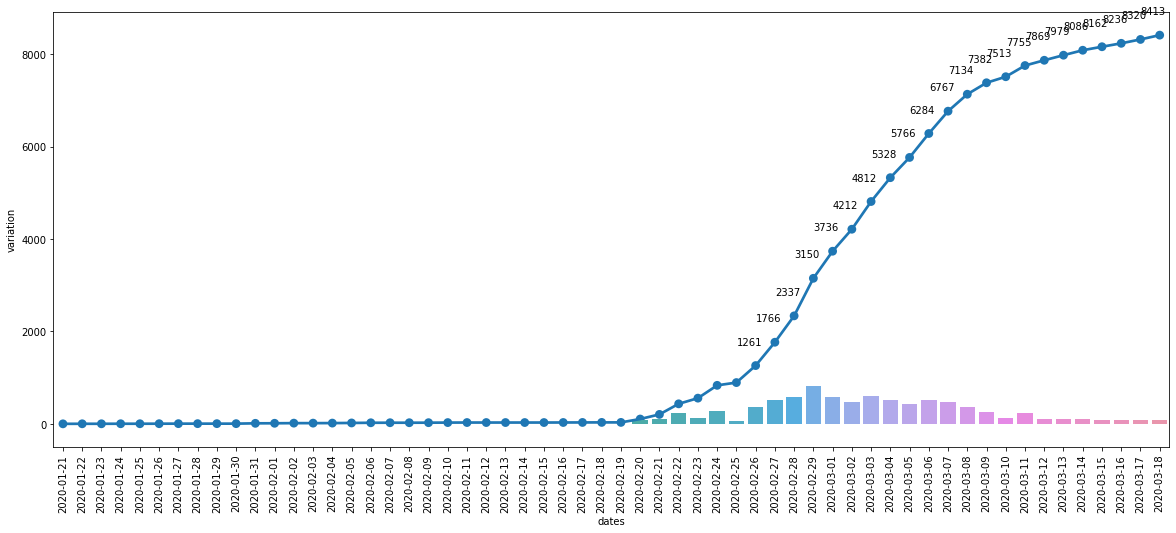

In [135]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.pointplot(data=df_dates, x='dates', y='confirmed')
g = sns.barplot(data=df_dates, x='dates', y='variation')
for i, s in enumerate(df_dates['confirmed']) :
    if s > 1000 :
        g.text(x=i-1, y=s+450, s=s)

In [165]:
path = 'data/'
patient_data_path = path + 'Patientinfo.csv'
df_patient = pd.read_csv(patient_data_path)

# 여기까지@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

### 코로나바이러스감염증-19 (COVID-19) 국내 확진자 정보

### patient 데이터 구조 확인

In [166]:
df_patient.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2002000001,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1000000002,2.0,NaN,2020-01-31,2020-02-24,NaN,released


### 결측치 처리

In [156]:
for col in df_patient.columns:
    if col == "global_num" or col == "birth_year" or col == "disease" or col == "infection_case" or col == "infection_order" or col == "infected_by" or col == "contact_number" or col == "symptom_onset_date" or col == "released_date" or col == "deceased_date":
        del df_patient[col]

In [167]:
df_patient.isna().sum()

patient_id               0
global_num             952
sex                    291
birth_year             555
age                    297
country                  0
province                 0
city                   168
disease               2093
infection_case        1159
infection_order       2081
infected_by           1738
contact_number        1731
symptom_onset_date    1967
confirmed_date         269
released_date         1919
deceased_date         2083
state                    0
dtype: int64

In [158]:
df_patient = df_patient.dropna(axis=0)

### 데이터 전처리

In [161]:
df_patient['birth_year'] = df_patient.birth_year.fillna(0).astype(int)
df_patient['birth_year'] = df_patient['birth_year'].map(lambda i : i if i > 0 else np.nan)

AttributeError: 'DataFrame' object has no attribute 'birth_year'

In [17]:
df_patient['confirmed_date'] = pd.to_datetime(df_patient['confirmed_date'])
daily_count = df_patient.groupby(df_patient['confirmed_date'])['patient_id'].count()
accumulated_count = daily_count.cumsum()

In [18]:
df_patient['age'] = 2020 - df_patient.birth_year

In [19]:
import math
def group_age(age):
    if age >= 0:
        if age % 10 != 0:
            lower = int(math.floor(age/10.0)) * 10
            upper = int(math.ceil(age/10.0)) * 10 - 1
            return f"{lower}-{upper}"
    return "Unknown"

df_patient['age_range'] = df_patient['age'].apply(group_age)

In [20]:
df_patient['age_range'].value_counts()

Unknown    7258
20-29       141
50-59       132
40-49       103
30-39        86
60-69        84
70-79        33
80-89        15
10-19        12
0-9           4
90-99         1
Name: age_range, dtype: int64

In [21]:
# import math
# def group_ages(age):
#     if age >= 0:
#         if age % 10 != 0:
#             lower = int(math.floor(age/10.0)) * 10
#             return lower
#     return 'Unknown'

# df_patient['age_ranges'] = df_patient['age'].apply(group_ages)

In [22]:
# df_patient['age_ranges'].value_counts()

In [138]:
patient = df_patient

In [139]:
date_cols = ['confirmed_date','released_date','deceased_date']
for col in date_cols:
    patient[col] = pd.to_datetime(patient[col])

In [140]:
patient['time_to_release_since_confirmed'] = patient['released_date'] - patient['confirmed_date']

In [141]:
patient['time_to_death_since_confirmed'] = patient['deceased_date'] - patient['confirmed_date']

In [142]:
patient['duration_since_confirmed'] = patient[['time_to_release_since_confirmed','time_to_death_since_confirmed']].min(axis=1)

In [143]:
patient['duration_days'] = patient['duration_since_confirmed'].dt.days

In [144]:
age_ranges = sorted(set([ar for ar in patient['age_range']
                        if ar != "Unknown"]))

In [145]:
patient

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,...,released_date,deceased_date,state,confirmed_md,age,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days
0,1,female,1984.0,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,...,2020-02-06,NaT,released,01-20,36.0,30-39,17 days,NaT,17 days,17.0
1,2,male,1964.0,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,...,2020-02-05,NaT,released,01-24,56.0,50-59,12 days,NaT,12 days,12.0
2,3,male,1966.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,...,2020-02-12,NaT,released,01-26,54.0,50-59,17 days,NaT,17 days,17.0
3,4,male,1964.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,...,2020-02-09,NaT,released,01-27,56.0,50-59,13 days,NaT,13 days,13.0
4,5,male,1987.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,...,2020-03-02,NaT,released,01-30,33.0,30-39,32 days,NaT,32 days,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7864,7865,NaN,NaN,Korea,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,isolated,03-11,NaN,Unknown,NaT,NaT,NaT,NaN
7865,7866,NaN,NaN,Korea,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,isolated,03-11,NaN,Unknown,NaT,NaT,NaT,NaN
7866,7867,NaN,NaN,Korea,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,isolated,03-11,NaN,Unknown,NaT,NaT,NaT,NaN
7867,7868,NaN,NaN,Korea,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,isolated,03-11,NaN,Unknown,NaT,NaT,NaT,NaN


In [146]:
patient['state_by_gender'] = patient['state'] + '_' + patient['sex']

Text(0.5, 1.0, 'Accumulated Confirmed Count')

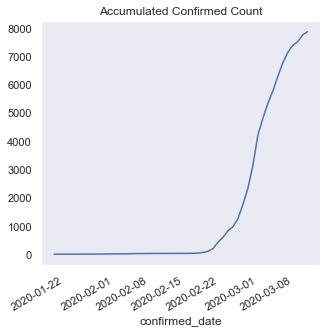

In [147]:
accumulated_count.plot()
plt.title('Accumulated Confirmed Count')

## 일자별 확진자와 누적 확진자

In [148]:
infected_patient = patient.shape[0]
rp = patient.loc[patient['state'] == 'released'].shape[0]
dp = patient.loc[patient['state'] == 'deceased'].shape[0]
ip = patient.loc[patient['state'] == 'isolated'].shape[0]
rp = rp/patient.shape[0]
dp = dp/patient.shape[0]
ip = ip/patient.shape[0]
print('The percentage of recovered is ' + str(rp*100))
print('The percentage of deceased is ' + str(dp*100))
print('The percentage of isolated is ' + str(ip*100))

The percentage of recovered is 0.7116533231668573
The percentage of deceased is 0.4574914220358368
The percentage of isolated is 98.8308552547973


In [163]:
df_patient['state'].value_counts()

isolated    1838
released     244
deceased      30
Name: state, dtype: int64

In [150]:
states = pd.DataFrame(patient['state'].value_counts())
states['status'] = states.index
states.rename(columns = {'state':'count'}, inplace = True)

fig = px.pie(states,
            values = 'count',
            names = 'status',
            title = 'Current state of patients',
            template = 'seaborn')
fig.update_traces(rotation=90, pull=0.05, textinfo='value+percent+label')
fig.show()

In [151]:
released = df_patient[df_patient.state == 'released']
released.head()

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,...,deceased_date,state,confirmed_md,age,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
0,1,female,1984.0,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,...,NaT,released,01-20,36.0,30-39,17 days,NaT,17 days,17.0,released_female
1,2,male,1964.0,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,...,NaT,released,01-24,56.0,50-59,12 days,NaT,12 days,12.0,released_male
2,3,male,1966.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,...,NaT,released,01-26,54.0,50-59,17 days,NaT,17 days,17.0,released_male
3,4,male,1964.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,...,NaT,released,01-27,56.0,50-59,13 days,NaT,13 days,13.0,released_male
4,5,male,1987.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,...,NaT,released,01-30,33.0,30-39,32 days,NaT,32 days,32.0,released_male


In [152]:
isolated = df_patient[df_patient.state == 'isolated']
isolated.head()

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,...,deceased_date,state,confirmed_md,age,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
25,26,male,1968.0,Korea,capital area,NaN,NaN,contact with patient,1.0,27.0,...,NaT,isolated,02-09,52.0,50-59,NaT,NaT,NaT,NaN,isolated_male
26,27,female,1982.0,China,capital area,NaN,NaN,visit to China,1.0,NaN,...,NaT,isolated,02-09,38.0,30-39,NaT,NaT,NaT,NaN,isolated_female
28,29,male,1938.0,Korea,capital area,NaN,NaN,contact with patient,4.0,83.0,...,NaT,isolated,02-16,82.0,80-89,NaT,NaT,NaT,NaN,isolated_male
29,30,female,1952.0,Korea,capital area,NaN,NaN,contact with patient,5.0,29.0,...,NaT,isolated,02-16,68.0,60-69,NaT,NaT,NaT,NaN,isolated_female
30,31,female,1959.0,Korea,Daegu,NaN,Shincheonji Church,NaN,NaN,NaN,...,NaT,isolated,02-18,61.0,60-69,NaT,NaT,NaT,NaN,isolated_female


In [153]:
deceased = df_patient[df_patient.state == 'deceased']
deceased.head()

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,...,deceased_date,state,confirmed_md,age,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
37,38,female,1963.0,Korea,Daegu,1.0,NaN,NaN,NaN,NaN,...,2020-02-23,deceased,02-18,57.0,50-59,NaT,5 days,5 days,5.0,deceased_female
53,54,male,1963.0,Korea,Gyeongsangbuk-do,1.0,Cheongdo Daenam Hospital,NaN,NaN,NaN,...,2020-02-23,deceased,02-19,57.0,50-59,NaT,4 days,4 days,4.0,deceased_male
54,55,male,1961.0,Korea,Gyeongsangbuk-do,1.0,Cheongdo Daenam Hospital,NaN,NaN,NaN,...,2020-02-23,deceased,02-19,59.0,50-59,NaT,4 days,4 days,4.0,deceased_male
103,104,male,1957.0,Korea,Gyeongsangbuk-do,1.0,Cheongdo Daenam Hospital,NaN,NaN,NaN,...,2020-02-19,deceased,02-20,63.0,60-69,NaT,-1 days,-1 days,-1.0,deceased_male
106,107,male,1953.0,Korea,Gyeongsangbuk-do,1.0,Cheongdo Daenam Hospital,NaN,NaN,NaN,...,2020-02-24,deceased,02-21,67.0,60-69,NaT,3 days,3 days,3.0,deceased_male


## 격리해제된 사람들의 연령대 분포

NameError: name 'released' is not defined

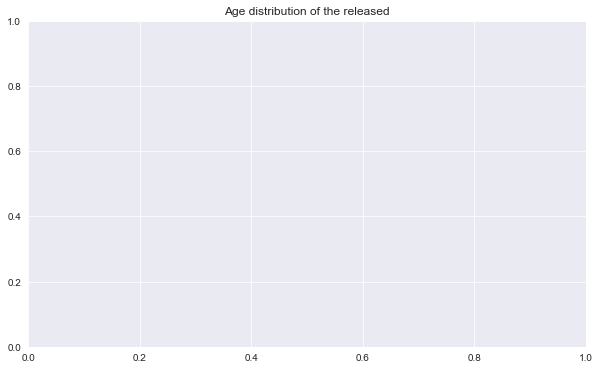

In [164]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
plt.title('Age distribution of the released')
sns.kdeplot(data=released['age'], shade=True)

## 격리 중인 사람들의 연령대 분포

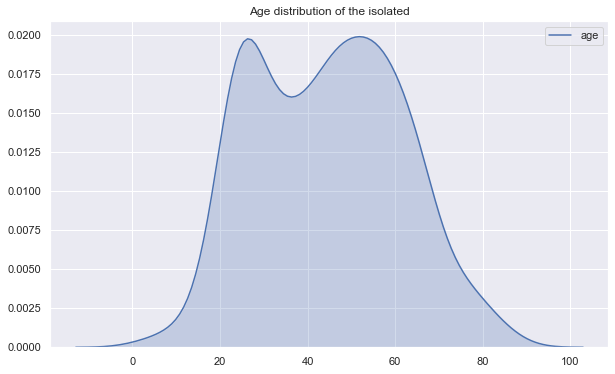

In [155]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
plt.title('Age distribution of the isolated')
sns.kdeplot(data=isolated['age'], shade=True)

## 사망한 사람들의 연령대 분포

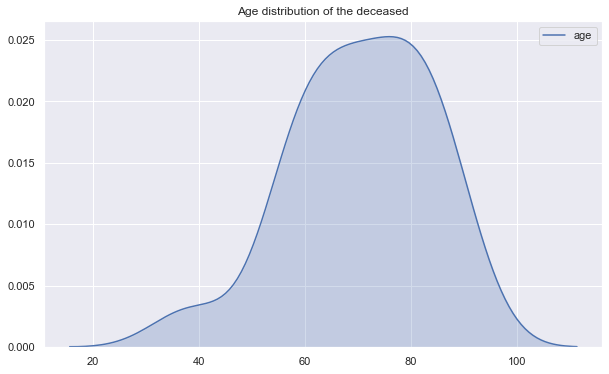

In [156]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
plt.title('Age distribution of the deceased')
sns.kdeplot(data=deceased['age'], shade=True)

In [157]:
male_deceased = deceased[deceased.sex=='male']
female_deceased = deceased[deceased.sex=='female']

## 성별별 사망한 사람들의 연령대 분포 

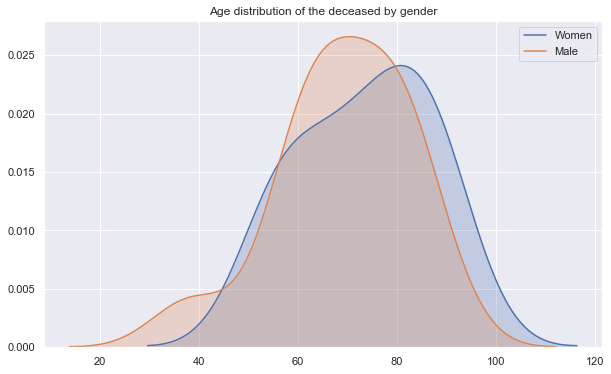

In [158]:
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
plt.title('Age distribution of the deceased by gender')
sns.kdeplot(data=female_deceased['age'], label='Women',shade=True)
sns.kdeplot(data=male_deceased['age'], label='Male',shade=True)

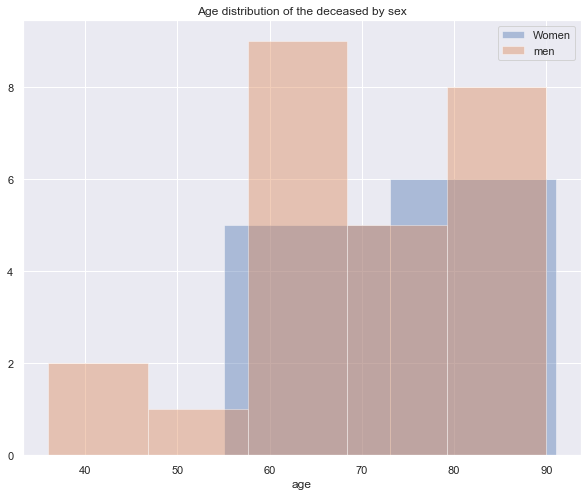

In [159]:
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
sns.distplot(a=female_deceased['age'],label='Women',kde=False)
sns.distplot(a=male_deceased['age'],label='men',kde=False)
plt.title('Age distribution of the deceased by sex')
plt.legend()

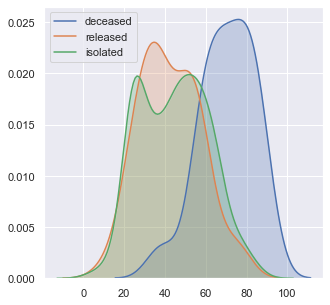

In [160]:
sns.kdeplot(data=deceased['age'], label='deceased', shade=True)
sns.kdeplot(data=released['age'], label='released', shade=True)
sns.kdeplot(data=isolated['age'], label='isolated', shade=True)

## 성별별 사망자수

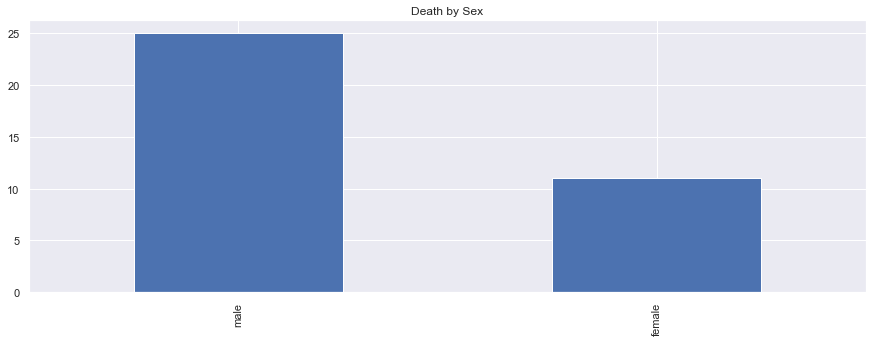

In [161]:
plt.figure(figsize=(15,5))
plt.title('Death by Sex')
deceased.sex.value_counts().plot.bar()

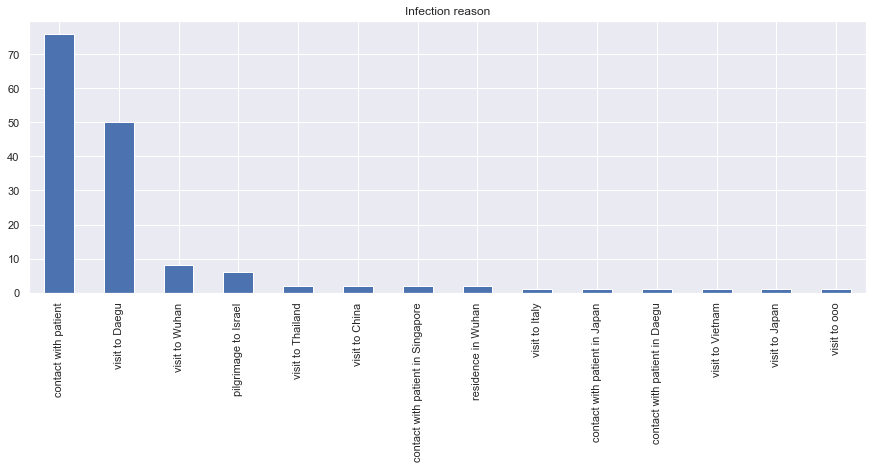

In [162]:
plt.figure(figsize=(15,5))
plt.title('Infection reason')
df_patient.infection_reason.value_counts().plot.bar()

In [163]:
fig = px.pie(values=df_patient.groupby(['infection_reason']).size().values,
            names=df_patient.groupby(['infection_reason']).size().index)
fig.update_layout(
    font=dict(
        size=15,
        color='#242323'
    )
    )

py.iplot(fig)

## 환자들의 상태

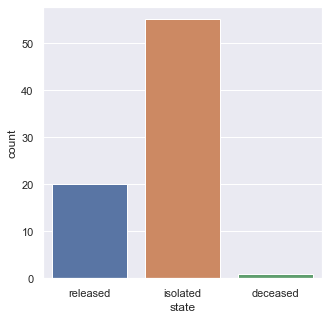

In [164]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[
    (df_patient['infection_reason']=='contact with patient')])              

## 남성 환자들의 상태

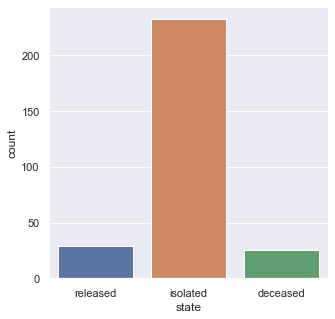

In [165]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[
    (df_patient['sex']=='male')])

## 여성 환자들의 상태

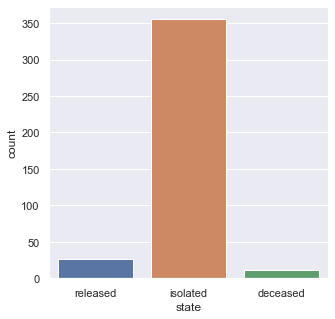

In [166]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[
    (df_patient['sex']=='female')])

## 성별과 연령별 상태

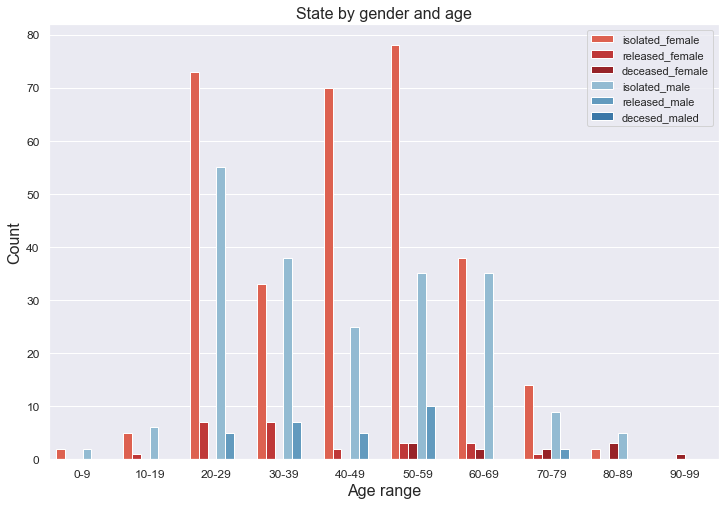

In [167]:
age_gender_hue_order = ['isolated_female', 'released_female', 'deceased_female',
                        'isolated_male', 'released_male', 'decesed_maled']
custom_palette = sns.color_palette('Reds')[3:6] + sns.color_palette('Blues')[2:5]

plt.figure(figsize=(12, 8))
sns.countplot(x='age_range',
             hue='state_by_gender',
             order=age_ranges,
             hue_order=age_gender_hue_order,
             palette=custom_palette,
             data=patient)
plt.title('State by gender and age', fontsize=16)
plt.xlabel('Age range', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right')
plt.show()

## 성별과 상태별 지역

C:\Users\wonho\anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



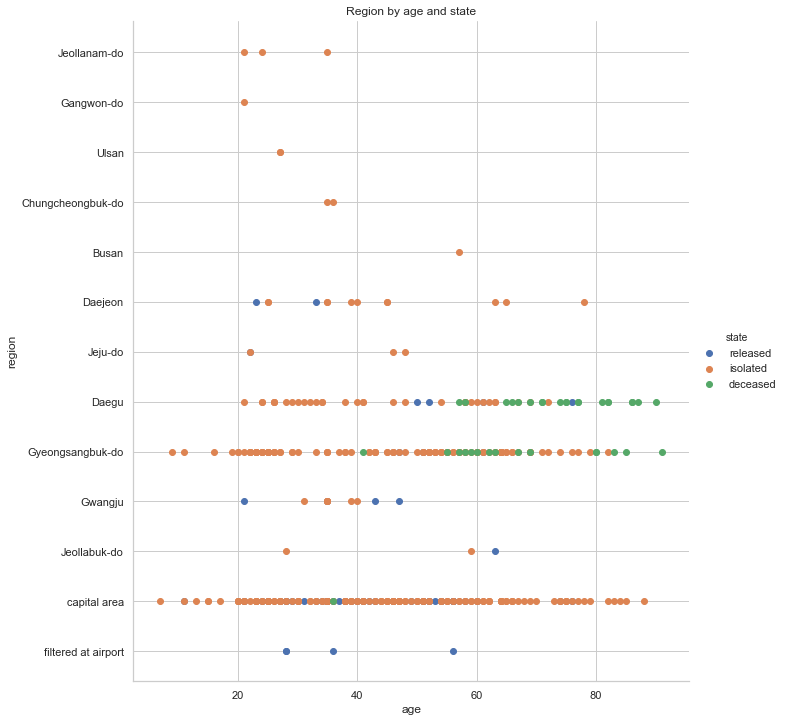

In [168]:
sns.set_style('whitegrid')
sns.FacetGrid(df_patient, hue='state', size=10).map(
    plt.scatter, 'age', 'region').add_legend()
plt.title('Region by age and state')
plt.show()

## 지역별 확진자

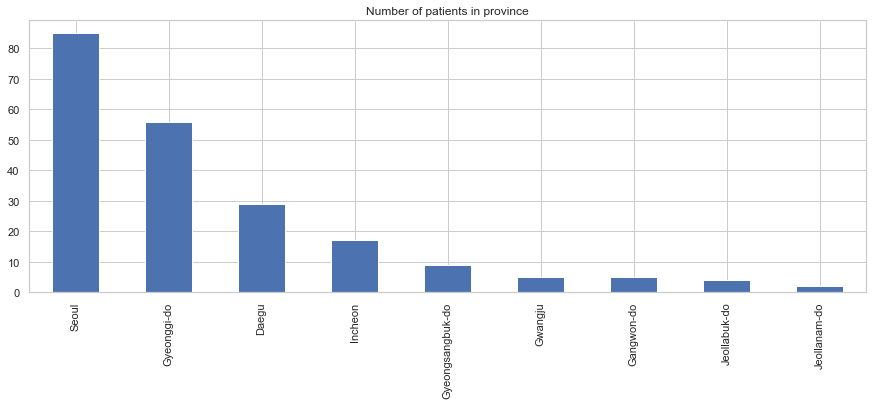

In [169]:
plt.figure(figsize=(15,5))
plt.title('Number of patients in province')
df_route.province.value_counts().plot.bar();

In [170]:
fig = px.pie(values=df_route.groupby(['province']).size().values,
             names=df_route.groupby(['province']).size().index)
fig.update_layout(
    font=dict(
        size=15,
        color="#242323"
    )
    )   
    
py.iplot(fig)

## 도시별 확진자

In [171]:
df_route

,patient_id,date,province,city,visit,latitude,longitude
0,1,2020-01-19,Incheon,Jung-gu,airport,37.460459,126.440680
1,1,2020-01-20,Incheon,Seo-gu,hospital_isolated,37.478832,126.668558
2,2,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.562143,126.801884
3,2,2020-01-23,Seoul,Jung-gu,hospital_isolated,37.567454,127.005627
4,3,2020-01-20,Incheon,Jung-gu,airport,37.460459,126.440680
...,...,...,...,...,...,...,...
207,55,2020-02-19,Gyeongsangbuk-do,Pohang-si,hospital_isolated,36.034762,129.355059
208,56,2020-02-17,Gyeongsangbuk-do,Pohang-si,hospital,37.576420,126.972759
209,56,2020-02-13,Seoul,Dongdaemun-gu,hospital,37.593919,127.051291
210,56,2020-02-13,Seoul,Jongno-gu,hospital,37.581837,126.969186


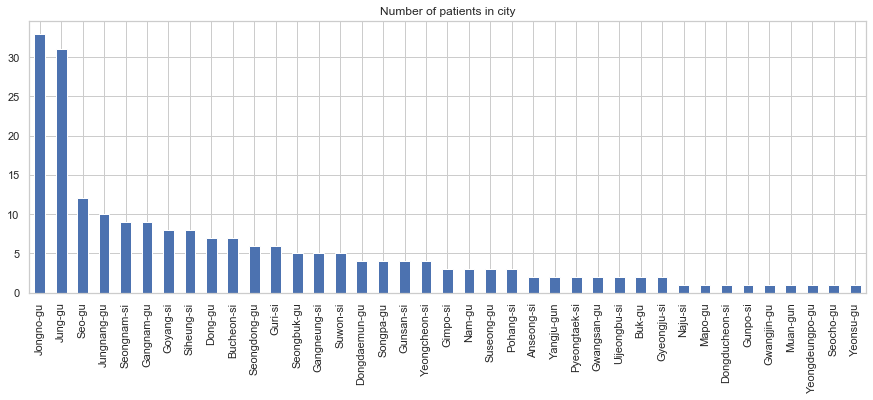

In [172]:
plt.figure(figsize=(15,5))
plt.title('Number of patients in city')
df_route.city.value_counts().plot.bar()

In [173]:
fig = px.pie(values=df_route.groupby(['city']).size().values,
             names=df_route.groupby(['city']).size().index)
fig.update_layout(
    font=dict(
        size=15,
        color="#242323"
    )
    )   
    
py.iplot(fig)

## 사람들이 감염된 장소

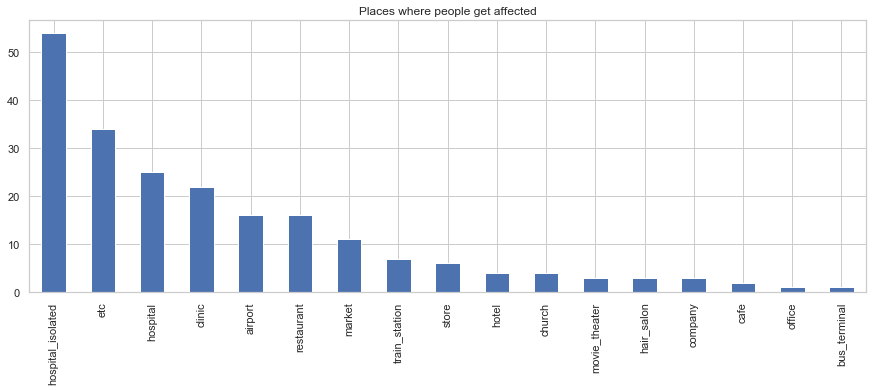

In [174]:
plt.figure(figsize=(15,5))
plt.title('Places where people get affected')
df_route.visit.value_counts().plot.bar()

In [175]:
fig = px.pie(values=df_route.groupby(['visit']).size().values,
             names=df_route.groupby(['visit']).size().index)
fig.update_layout(
    font=dict(
        size=15,
        color="#242323"
    )
    )   
    
py.iplot(fig)

## 확진 후 격리해제 또는 사망으로 가는 시간

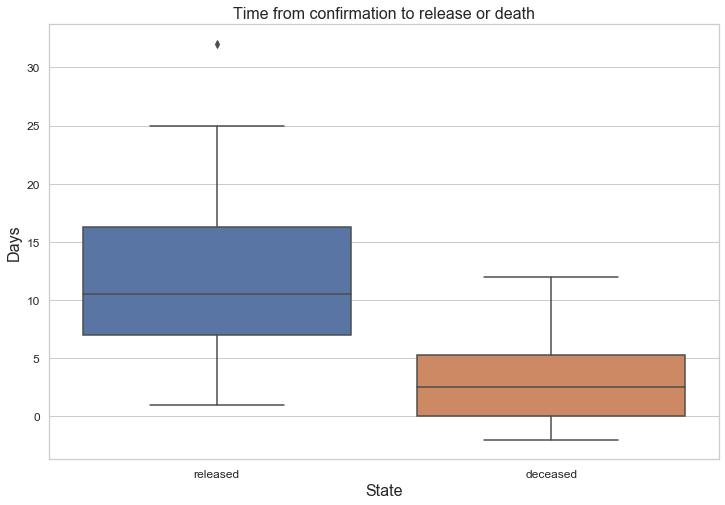

In [176]:
plt.figure(figsize=(12,8))
sns.boxplot(x='state',
           y='duration_days',
           order=['released','deceased'],
           data=patient)
plt.title('Time from confirmation to release or death',
         fontsize=16)
plt.xlabel('State', fontsize=16)
plt.ylabel('Days', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 성별별 확진 후 격리해제 또는 사망으로 가는 시간

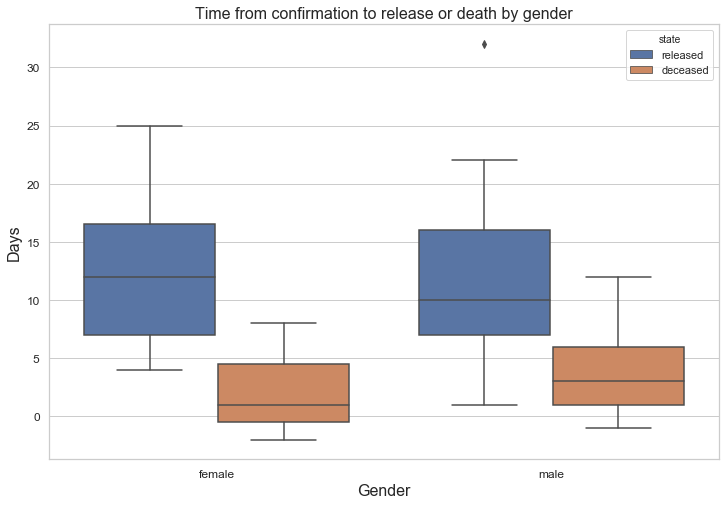

In [177]:
order_duration_sex=['female', 'male']
plt.figure(figsize=(12, 8))
sns.boxplot(x='sex',
           y='duration_days',
           order=order_duration_sex,
           hue='state',
           hue_order=['released','deceased'],
           data=patient)
plt.title("Time from confirmation to release or death by gender",
         fontsize=16)
plt.xlabel('Gender', fontsize=16)
plt.ylabel('Days', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

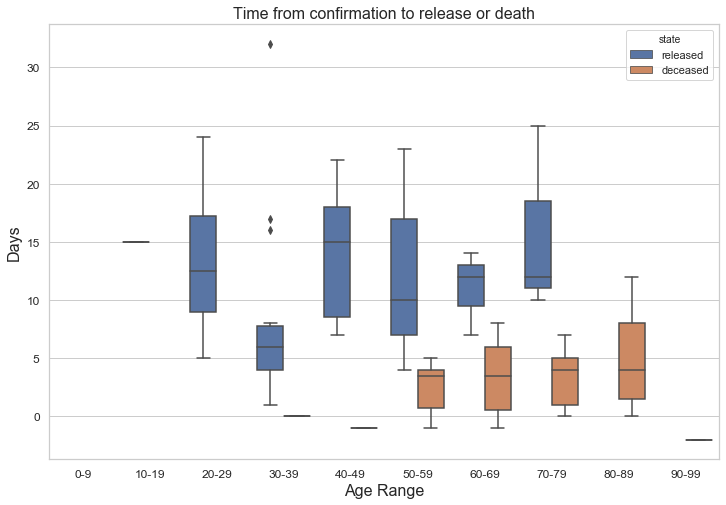

In [178]:
order_duration_age=sorted(patient['age_range'].unique())[:-1]
plt.figure(figsize=(12,8))
sns.boxplot(x='age_range',
           y='duration_days',
           order=order_duration_age,
           hue='state',
           hue_order=['released','deceased'],
           data=patient)
plt.title('Time from confirmation to release or death',
         fontsize=16)
plt.xlabel("Age Range", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()